Dans ce rapport nous allons analyser la base *wine-quality-red*, disponible au lien suivant :

https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

Le rapport est constitué de deux parties:
- Analyse des données
- Classification

La partie analyse nous permettra de comprendre notre jeu de donnée ainsi que de dégager des problématiques auxquelles nous pourrons répondre dans la partie classificatiion.

# Analyse du jeu de données

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, delimiter=';')
df = data.copy()
df.sample(8)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1513,6.4,0.560,0.15,1.8,0.078,17.0,65.0,0.99294,3.33,0.60,10.5,6
751,8.3,0.650,0.10,2.9,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,5
1535,7.0,0.550,0.13,2.2,0.075,15.0,35.0,0.99590,3.36,0.59,9.7,6
760,9.0,0.580,0.25,2.8,0.075,9.0,104.0,0.99779,3.23,0.57,9.7,5
1162,8.5,0.320,0.42,2.3,0.075,12.0,19.0,0.99434,3.14,0.71,11.8,7
1549,7.4,0.360,0.30,1.8,0.074,17.0,24.0,0.99419,3.24,0.70,11.4,8
1331,7.8,0.870,0.26,3.8,0.107,31.0,67.0,0.99668,3.26,0.46,9.2,5
1567,7.2,0.695,0.13,2.0,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5


## Description des variables

- `fixed acidity` (g(tartaric acid)/dm3): la plupart des acides présents dans le vin sont fixes ou non volatiles (ne s'évaporent pas facilement).
- `volatile acidity` (g(acetic acid)/dm3): la quantité d'acide acétique dans le vin, qui, à des niveaux trop élevés, peut donner un goût désagréable de vinaigre.
- `citric acid` (g/dm3): présent en petites quantités, l'acide citrique peut ajouter de la fraîcheur et de la saveur au vin.
- `residual sugar` (g/dm3): la quantité de sucre restant après l'arrêt de la fermentation, il est rare de trouver des vins avec moins de 1 gramme/litre et les vins avec plus de 45 grammes/litre sont considérés comme doux.
- `chlorides` (g(sodium chloride)/dm3): la quantité de sel dans le vin.
- `free sulfur dioxide` (mg/dm3): la forme libre du SO2 existe en équilibre entre le SO2 moléculaire (sous forme de gaz dissous) et l'ion bisulfite ; elle empêche la croissance microbienne et l'oxydation du vin.
- `total sulfur dioxide` (mg/dm3): quantité de formes libres et liées de S02 ; à faible concentration, le SO2 est généralement indétectable dans le vin, mais à des concentrations de SO2 libre supérieures à 50 ppm, le SO2 devient évident au nez et au goût du vin.
- `density` (g/cm3): la densité du vin est proche de celle de l'eau, selon le pourcentage d'alcool et la teneur en sucre.
- `pH`: décrit l'acidité ou la basicité d'un vin sur une échelle allant de 0 (très acide) à 14 (très basique) ; la plupart des vins se situent entre 3 et 4 sur l'échelle du pH.
- `sulphates` (g(potassium sulphate)/dm3): un additif du vin qui peut contribuer aux niveaux de gaz sulfureux (S02), qui agit comme un antimicrobien et un antioxydant.
- `alcohol` (% vol.): le pourcentage d'alcool contenu dans le vin.
- `quality`: variable de sortie (basée sur des données sensorielles, note entre 0 et 10).
 
 
 ## Généralités
 
 Une première analyse de cette base de donnée peut être effectuée avec le module `ProfileReport` du package `pandas_profiling`. Le code correspondant ainsi que le détail des résultats pevent être retrouvé en annexe 1. Les points importants sont les suivants:
- On dispose de 1599 observations et de 11 variables quantitative continues et d'une variable qualitative ordinale, `quality`, que l'on va tenter de prédire.
- Il n'y a pas de valeurs manquantes.
- Il y a 15% de lignes dupliquées.
- Il y a 8,3% de zeros pour la variable `citric acid`.
- La répartition des valeurs pour la variable `quality` est très inégale.

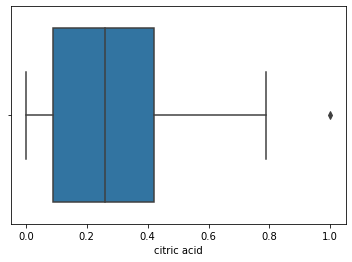

In [2]:
sns.boxplot(x='citric acid', data=df);

Les zeros de la variable `citric acid` ne semblent pas abérrants au vu de la distribution de la variable.

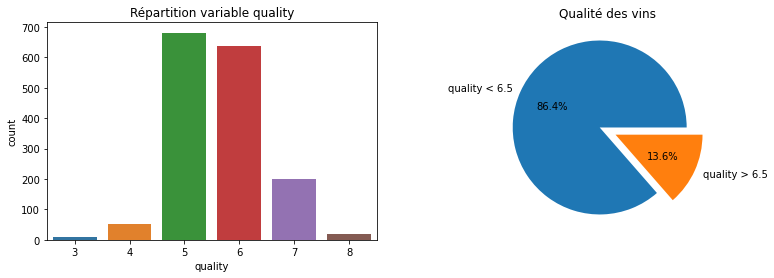

In [3]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sns.countplot(x='quality', data=df)
plt.title('Répartition variable quality');
plt.subplot(1,2,2)
bons_vins = df.quality > 6.5
labels = labels=['quality < 6.5', 'quality > 6.5']
plt.pie(x=bons_vins.value_counts(), autopct="%.1f%%", explode=[0.1]*2, labels=labels)
plt.title('Qualité des vins');

Les classes sont assez déséquilibrées, il y a beaucoup plus de vins avec une note moyenne que de vins avec une mauvaise ou une bonne note.

## Statistiques univariés

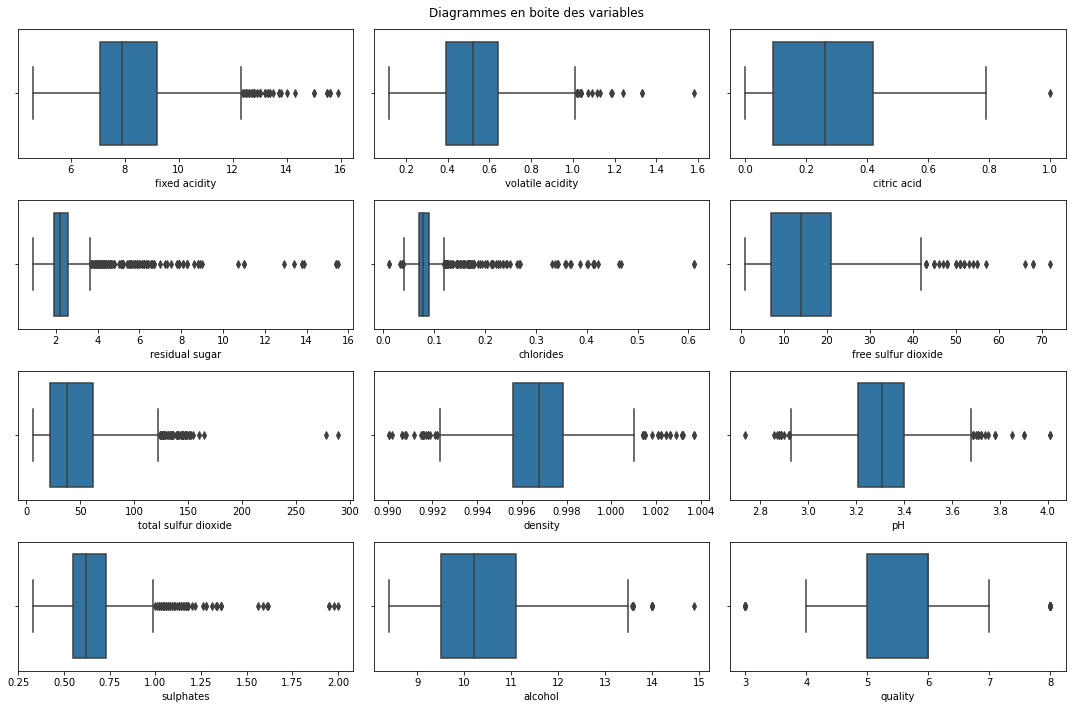

In [4]:
fig = plt.figure(figsize=(15,10))
for i, column in enumerate(df.columns):
    plt.subplot(4,3,i+1)
    fig.tight_layout(pad=2)
    sns.boxplot(x = column, data=df)
fig.suptitle('Diagrammes en boite des variables')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

On remarque qu'il y a beaucoup d'outliers pour la majorité des variables.

## Statistiques bivariées

Intéressons nous maintenant aux corrélations entre la variable objectif `quality` et les autres variables.

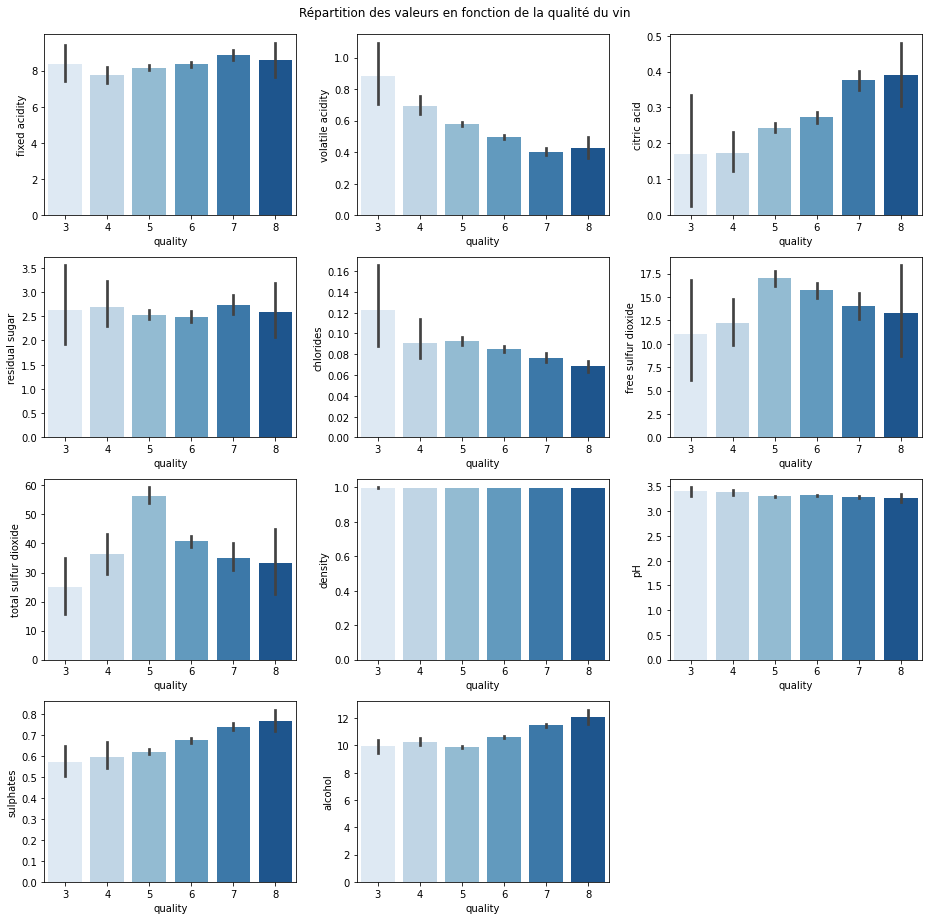

In [5]:
fig = plt.figure(figsize = (13, 13))
for i, column in enumerate(df.drop('quality', axis=1).columns):
    plt.subplot(4, 3, i+1)
    sns.barplot(x = 'quality', y = f'{column}', data = df, palette='Blues')
fig.suptitle('Répartition des valeurs en fonction de la qualité du vin')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

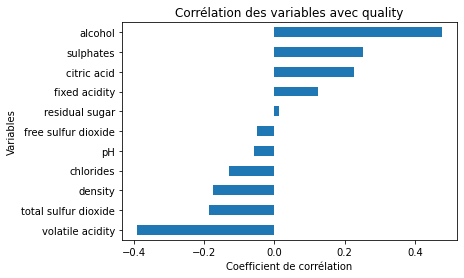

In [6]:
df.corr().quality.sort_values(ascending=False).iloc[1:12][::-1].plot(kind='barh')
plt.title("Corrélation des variables avec quality", size=12)
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Variables");

Nous pouvons voir que sur notre échantillon la variable `quality` est principalement corrélée:
- positivement avec la variable `alcohol`
- négativement avec la variable `volatile acidity`.

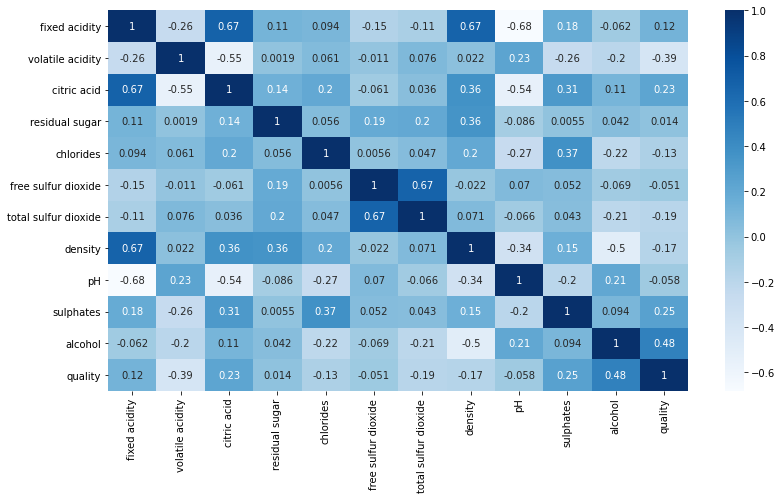

In [7]:
plt.figure(figsize=(13, 7))
sns.heatmap(df.corr(), cmap='Blues', annot=True);

Concernant les autres variables, on remarque des corrélations positives entre les variables `fixed acidity`, `citric acid` et `density`. Les variables `pH` et `fixed acidity` sont quant à elles corrélées négativement. Ces conclusions sont logiques si on considère les propriétés des physiques de ces éléments.

## Tests d'hypothèses

### Test de Student

Testons les hypothèses nulles suivantes avec un test de Student:

1. les vins bien notés ont un volume d'alcool moyen égaux aux autres vins
2. les vins moins bien notés présentes une acidité volatile moyenne égale aux autre vins.

Le tests de Student se font sur des classes équilibrées nous allons donc tirer au hasard dans **medium_rate_df** et **good_rate_df** des échantillons de taille 63.

In [8]:
def prepare_test(df):
    good_mark_df = df[df.quality > 6.5]
    #print('good_mark_df.shape:', good_mark_df.shape)
    medium_mark_df = df[df.quality < 6.5]
    #print('medium_mark_df.shape:', medium_mark_df.shape)
    balanced_medium_mark_df = medium_mark_df.sample(good_mark_df.shape[0])
    #print('balanced_med_mark_df.shape:', balenced_medium_mark_df.shape)
    return balanced_medium_mark_df, good_mark_df

In [9]:
from scipy.stats import ttest_ind, kstest

In [10]:
def test(col, test):
    medium_rate_df, good_rate_df = prepare_test(df)
    alpha = 0.01
    stat, p = test(medium_rate_df[col], good_rate_df[col])
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 0

In [11]:
print('H0 : Les vins bien notés ont les mêmes moyennes que les vins avec des notes moyennes.\n')
print(f'{str( ) :<25} {"ttest":<15} {"kstest"}')
for col in df.columns:
    print(f'{col :<25} {test(col, ttest_ind) :<15} {test(col, kstest) :<5}')

H0 : Les vins bien notés ont les mêmes moyennes que les vins avec des notes moyennes.

                          ttest           kstest
fixed acidity             H0 Rejetée      H0 Rejetée
volatile acidity          H0 Rejetée      H0 Rejetée
citric acid               H0 Rejetée      H0 Rejetée
residual sugar            0               0    
chlorides                 H0 Rejetée      H0 Rejetée
free sulfur dioxide       H0 Rejetée      0    
total sulfur dioxide      H0 Rejetée      H0 Rejetée
density                   H0 Rejetée      H0 Rejetée
pH                        0               0    
sulphates                 H0 Rejetée      H0 Rejetée
alcohol                   H0 Rejetée      H0 Rejetée
quality                   H0 Rejetée      H0 Rejetée


On peut conclure d'après le résultats des tests que les variables `residual sugar` et `pH` ne semblent pas avoir d'impact significatif sur la variable `quality`.

### Test du χ2

Le test du χ2 mesure la dépendance entre les variables stochastiques, donc l'utilisation de cette fonction détecte les caractéristiques qui sont les plus susceptibles d'être indépendantes de la variable objectif $y$ et donc non pertinentes pour la classification.

In [12]:
df.drop(['quality'], axis=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [13]:
from sklearn.feature_selection import chi2
X = df.drop(['quality'], axis=1)
y = df.quality
test_values, p_values = np.round(chi2(X, y),2)
res = pd.DataFrame({'Val. test':test_values, 'p-values':p_values, 'H0 rejected':np.round(chi2(X, y),2)[1] < 0.1}, index=X.columns)
res

,Val. test,p-values,H0 rejected
fixed acidity,11.26,0.05,True
volatile acidity,15.58,0.01,True
citric acid,13.03,0.02,True
residual sugar,4.12,0.53,False
chlorides,0.75,0.98,False
free sulfur dioxide,161.94,0.00,True
total sulfur dioxide,2755.56,0.00,True
density,0.00,1.00,False
pH,0.15,1.00,False
sulphates,4.56,0.47,False


Seules les variables `fixed acidity`, `volatile acidity`, `citric acid`, `free sulfur dioxide`, `total sulfur dioxide` et `alcohol` semblent avoir une dépendance avec la variable `quality`.

## Bilan de l'analyse

Le jeu de données ne présente pas de difficulté particulière pour le nettoyage et la préparation si ce n'est le fait que la proportion de vins jugés comme bons est assez faible. Il serait intéressant de remédier à ce problème pour obtenir de meilleures prédictions. Il est en effet plus dur pour un modèle de Machine Learning d'apprendre les caratéristiques d'une classe minoritaire. De plus, un modèle naïf peut atteindre une précision raisonnable en prédisant simplement la classe majoritaire dans tous les cas. 

En outre, certaines variables disposent de nombreux outliers.

Il serait avant tout intéressant de procéder à du feature engineering (ré-échantillonage, sélection de variables).